## We implement here Adaboost from Scratch

https://www.kdnuggets.com/2020/12/implementing-adaboost-algorithm-from-scratch.html

Load the iris dataset


In [18]:
import numpy as np
import sklearn
from sklearn import datasets
iris = datasets.load_iris()

In [2]:
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [3]:
iris['data'][0:10]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1]])

In [4]:
iris['target'][0:10]
unique, counts = np.unique(iris['target'], return_counts=True)
unique, counts

(array([0, 1, 2]), array([50, 50, 50]))

In [5]:
iris['target_names']

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [6]:
iris['feature_names']

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [7]:
## Plot dataset on first two features - e.g

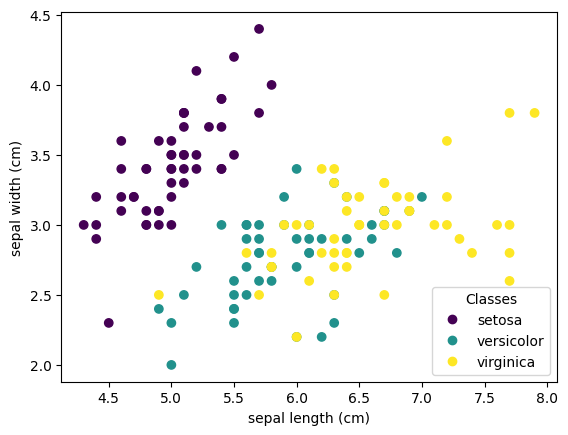

In [8]:
import matplotlib.pyplot as plt

_, ax = plt.subplots()
scatter = ax.scatter(iris.data[:, 0], iris.data[:, 1], c=iris.target)
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])
_ = ax.legend(scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes")

In [9]:
import pandas as pd
iris_df = pd.DataFrame(iris['data'], columns = iris['feature_names'])
iris_df = iris_df.rename(columns={'sepal length (cm)':'sepal_length', 
                                'sepal width (cm)':'sepal_width', 
                                'petal length (cm)':'petal_length', 
                                'petal width (cm)':'petal_width'})
iris_df['species'] = iris['target']
iris_df['species'] = iris_df['species'].map({ k:v for k,v in enumerate(iris['target_names'])})
iris_df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [10]:
# AdaBoost Algorithm from scratch:
# considered only two classes (Versicolor and Virginica) for better understanding.

example = iris_df[(iris_df['species'] == 'versicolor')|(iris_df['species'] == 'virginica')]

In [11]:
example

,sepal_length,sepal_width,petal_length,petal_width,species
50,7.0,3.2,4.7,1.4,versicolor
51,6.4,3.2,4.5,1.5,versicolor
52,6.9,3.1,4.9,1.5,versicolor
53,5.5,2.3,4.0,1.3,versicolor
54,6.5,2.8,4.6,1.5,versicolor
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [12]:
# Step 1: Assign Equal Weights to all the observations


In [13]:
example['wt1'] = 1.0/(example.shape[0])

/Users/jvsingh/anaconda3/envs/aaml/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
1.0/(example.shape[0])

0.01

In [15]:
example

,sepal_length,sepal_width,petal_length,petal_width,species,wt1
50,7.0,3.2,4.7,1.4,versicolor,0.01
51,6.4,3.2,4.5,1.5,versicolor,0.01
52,6.9,3.1,4.9,1.5,versicolor,0.01
53,5.5,2.3,4.0,1.3,versicolor,0.01
54,6.5,2.8,4.6,1.5,versicolor,0.01
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica,0.01
146,6.3,2.5,5.0,1.9,virginica,0.01
147,6.5,3.0,5.2,2.0,virginica,0.01
148,6.2,3.4,5.4,2.3,virginica,0.01


# Step 2: Classify random samples using stumps
Draw random samples with replacement from original data with the probabilities equal to the sample weights and fit the model. Here the model (base learners) used in AdaBoost is decision tree. Decision trees are created with one depth which has one node and two leaves also referred to as stumps. Fit the model to the random samples and predict the classes for the original data.

In [28]:
# simple random sample with replacement
np.random.seed(142)
example1 = example.sample(len(example), replace = True, weights = example['wt1'])

In [29]:
# fittgin the Decision Tree model with depth one as we want just stump
from sklearn import tree
clf_gini = sklearn.tree.DecisionTreeClassifier(criterion = 'gini', random_state = 100, max_depth = 1)
clf = clf_gini.fit(example1[["sepal_length","sepal_width","petal_length","petal_width"]],
                   example1[["species"]])

In [30]:
y_pred = clf.predict(example[["sepal_length","sepal_width","petal_length","petal_width"]])
y_pred

array(['versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'virginica', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'virginica',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'virginica', 'virginica', 'virginica',
       'virginica', 'virginica', 'virginica', 'virginica', 'virginica',
       'virginica', 'virginica', 'virginica', 'virginica', 'virginica',
       'virginica', 'virgini

## Step 3: Calculate Total Error
Total error is nothing but the sum of weights of misclassified record.

Total Error = Weights of misclassified records

Total error will be always between 0 and 1.

0 represents perfect stump (correct classification)

1 represents weak stump (misclassification)

In [37]:
example[['misclassified']] = [1 if pred != actual else 0 for pred, actual in zip(example['species'],y_pred)]

/Users/jvsingh/anaconda3/envs/aaml/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/jvsingh/anaconda3/envs/aaml/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [40]:
# error calculation
e1 = sum(example.misclassified * example.wt1)

## Step 4: Calculate Performance of the Stump
 
Using the Total Error, determine the performance of the base learner. The calculated performance of stump(α) value is used to update the weights in consecutive iteration and also used for final prediction calculation.

Performance of the stump(α) = ½ ln (1 – Total error/Total error)

In [43]:
import math 
alpha1 = 0.5 * math.log((1 - e1)/e1)

## Step 5: Update Weights
 
Based on the performance of the stump(α) update the weights. We need the next stump to correctly classify the misclassified record by increasing the corresponding sample weight and decreasing the sample weights of the correctly classified records.

New weight = Weight * e(performance) → misclassified records

New weight = Weight * e-(performance) → correctly classified records

In [57]:
# update weight
new_weight = example['wt1'] * [np.exp(-alpha1) if pred == actual else np.exp(alpha1) \
                               for pred, actual in zip(example['species'],y_pred)]

In [58]:
normalized_wt = new_weight/sum(new_weight)

In [59]:
example['wt2'] = normalized_wt

/Users/jvsingh/anaconda3/envs/aaml/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [60]:
example

,sepal_length,sepal_width,petal_length,petal_width,species,wt1,misclassified,wt2
50,7.0,3.2,4.7,1.4,versicolor,0.01,0,0.005319
51,6.4,3.2,4.5,1.5,versicolor,0.01,0,0.005319
52,6.9,3.1,4.9,1.5,versicolor,0.01,0,0.005319
53,5.5,2.3,4.0,1.3,versicolor,0.01,0,0.005319
54,6.5,2.8,4.6,1.5,versicolor,0.01,0,0.005319
...,...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica,0.01,0,0.005319
146,6.3,2.5,5.0,1.9,virginica,0.01,0,0.005319
147,6.5,3.0,5.2,2.0,virginica,0.01,0,0.005319
148,6.2,3.4,5.4,2.3,virginica,0.01,0,0.005319


## Step 6: Update weights in iteration
 
Use the normalized weight and make the second stump in the forest. Create a new dataset of same size of the original dataset with repetition based on the newly updated sample weight. So that the misclassified records get higher probability of getting selected. 

Repeat step 2 to 5 again by updating the weights for a particular number of iterations.